# Analysis of NYC Taxi Cab Data

## Import Libraries and Connect to Database

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Connect to database:
con = sqlite3.connect("NYC-Taxi.db")

## Extract Observations and Clean Data

In [2]:
# Store sample of green and yellow cab data into dataframes:
df1 = pd.read_sql(f"SELECT * FROM green_cabs ORDER BY random() LIMIT 500000", con)
df2 = pd.read_sql(f"SELECT * from yellow_cabs ORDER BY random() LIMIT 500000", con)

# Add labels for green and yellow cabs and rename pickup/dropoff datetime columns:
df1 = df1.rename(columns={"lpep_pickup_datetime": "pickup_datetime", "lpep_dropoff_datetime":"dropoff_datetime"})
df2 = df2.rename(columns={"tpep_pickup_datetime": "pickup_datetime", "tpep_dropoff_datetime":"dropoff_datetime"})
df1['cab'] = "green"
df2['cab'] = "yellow"

# Combine into one data frame:
frames = [df1, df2]
df = pd.concat(frames)

# Change format to datetime where necessary:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],unit='s')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'],unit='s')

df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Source_file,cab
0,2.0,2019-08-13 08:52:30,2019-08-13 09:18:59,N,1.0,166,138,1.0,8.10,28.0,...,6.00,6.12,NaN,0.3,40.92,1.0,1.0,0.00,green_tripdata_2019-08.csv,green
1,2.0,2019-02-26 13:28:41,2019-02-26 13:46:36,N,1.0,65,49,1.0,1.93,12.5,...,0.00,0.00,NaN,0.3,13.30,1.0,1.0,0.00,green_tripdata_2019-02.csv,green
2,2.0,2019-01-05 15:37:55,2019-01-05 16:00:26,N,1.0,51,168,1.0,8.69,27.5,...,0.00,0.00,NaN,0.3,28.30,1.0,1.0,NaN,green_tripdata_2019-01.csv,green
3,2.0,2019-10-26 21:59:03,2019-10-26 22:21:06,N,1.0,130,76,1.0,6.78,23.5,...,0.00,0.00,NaN,0.3,24.80,2.0,1.0,0.00,green_tripdata_2019-10.csv,green
4,2.0,2019-02-24 18:31:11,2019-02-24 18:45:56,N,1.0,42,239,1.0,3.32,13.0,...,3.31,0.00,NaN,0.3,19.86,1.0,1.0,2.75,green_tripdata_2019-02.csv,green


## Feature Engineering

In [3]:
# Store Pickup location borough names and merge to main data frame:
df_location = pd.read_csv("/Users/mbp/Documents/Side Projects/NYC Taxi Cab Scratch/taxi+_zone_lookup.csv")
df_location['DOLocationID'] = df_location['LocationID']
df_location = df_location.rename(columns = {'LocationID':'PULocationID'})

df = df.merge(df_location[['PULocationID', 'Borough', 'Zone']], on = "PULocationID", how = 'left')

# Include trip time:
df['trip_time'] = (df['dropoff_datetime'] - df['pickup_datetime']).astype('timedelta64[m]')

df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Source_file,cab,Borough,Zone,trip_time
0,2.0,2019-08-13 08:52:30,2019-08-13 09:18:59,N,1.0,166,138,1.0,8.10,28.0,...,0.3,40.92,1.0,1.0,0.00,green_tripdata_2019-08.csv,green,Manhattan,Morningside Heights,26.0
1,2.0,2019-02-26 13:28:41,2019-02-26 13:46:36,N,1.0,65,49,1.0,1.93,12.5,...,0.3,13.30,1.0,1.0,0.00,green_tripdata_2019-02.csv,green,Brooklyn,Downtown Brooklyn/MetroTech,17.0
2,2.0,2019-01-05 15:37:55,2019-01-05 16:00:26,N,1.0,51,168,1.0,8.69,27.5,...,0.3,28.30,1.0,1.0,NaN,green_tripdata_2019-01.csv,green,Bronx,Co-Op City,22.0
3,2.0,2019-10-26 21:59:03,2019-10-26 22:21:06,N,1.0,130,76,1.0,6.78,23.5,...,0.3,24.80,2.0,1.0,0.00,green_tripdata_2019-10.csv,green,Queens,Jamaica,22.0
4,2.0,2019-02-24 18:31:11,2019-02-24 18:45:56,N,1.0,42,239,1.0,3.32,13.0,...,0.3,19.86,1.0,1.0,2.75,green_tripdata_2019-02.csv,green,Manhattan,Central Harlem North,14.0


## Exploratory Data Analysis

In [4]:
# Summary stats and structure of data:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_time
count,964144.000000,964144.000000,1000000.000000,1000000.000000,964144.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,31.0,1000000.000000,1000000.000000,964144.000000,465553.000000,891764.000000,1000000.000000
mean,1.739828,1.123215,135.713822,145.299333,1.440748,3.147829,13.882024,0.813382,0.488526,1.589506,0.318560,0.0,0.283644,18.189067,1.361724,1.044944,1.344226,19.505494
std,0.449781,0.832768,74.153798,75.130276,1.106648,5.881133,24.237321,1.100682,0.083127,2.473542,1.496191,0.0,0.071348,25.369410,0.505171,0.207182,1.268679,83.517096
min,1.000000,1.000000,1.000000,1.000000,0.000000,-4311.350000,-890.000000,-4.500000,-0.500000,-21.000000,-18.000000,0.0,-0.300000,-890.300000,1.000000,1.000000,-2.750000,-52.000000
25%,1.000000,1.000000,74.000000,75.000000,1.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.300000,9.800000,1.000000,1.000000,0.000000,6.000000
50%,2.000000,1.000000,137.000000,145.000000,1.000000,1.780000,10.000000,0.500000,0.500000,1.000000,0.000000,0.0,0.300000,13.800000,1.000000,1.000000,2.500000,11.000000
75%,2.000000,1.000000,196.000000,226.000000,1.000000,3.500000,16.120000,1.000000,0.500000,2.360000,0.000000,0.0,0.300000,20.800000,2.000000,1.000000,2.500000,19.000000
max,4.000000,99.000000,265.000000,265.000000,9.000000,666.600000,20765.390000,17.500000,3.550000,222.000000,181.360000,0.0,0.300000,20765.390000,5.000000,2.000000,2.750000,9820.000000


The data contain large outliers (both positive and negative) in all of the numeric columns of interest. The data are trimmed to retain values that fall between the 1st and 99th percentiles (middle 98% of the data).

### Removing Outliers

In [19]:
# Trim dataset by finding the respective quantiles and removing all data above & below:
# Extract the numeric columns and remove outliers:
qlow = df.quantile(0.01)
df_num = df.iloc[:,np.r_[8:17,19,24]].columns
df_num = df[df_num][~((df[df_num] < qlow) |(df[df_num]> qhigh))]

# Create new dataframe with outliers removed:
dfs = [df.iloc[:,np.r_[0:8,17:19,20:24]], df_num]
df = pd.concat(dfs, axis = 1)

In [7]:
df.shape

(1000000, 25)

In [8]:
# Inspect cleaned dataset:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,payment_type,trip_type,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,congestion_surcharge,trip_time
count,964144.000000,964144.000000,1000000.000000,1000000.000000,964144.000000,964144.000000,465553.000000,988415.000000,985883.000000,992489.000000,997482.000000,990202.000000,996891.000000,31.0,997493.000000,982024.000000,891096.000000,990202.000000
mean,1.739828,1.123215,135.713822,145.299333,1.440748,1.361724,1.044944,2.966615,13.332177,0.789166,0.490996,1.454796,0.277540,0.0,0.285111,17.719395,1.347110,14.197842
std,0.449781,0.832768,74.153798,75.130276,1.106648,0.505171,0.207182,3.340025,10.296722,1.049303,0.066490,1.937265,1.253363,0.0,0.065154,12.285025,1.264773,11.515239
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.300000,0.000000,0.000000
25%,1.000000,1.000000,74.000000,75.000000,1.000000,1.000000,1.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.300000,9.850000,0.000000,6.000000
50%,2.000000,1.000000,137.000000,145.000000,1.000000,1.000000,1.000000,1.760000,10.000000,0.500000,0.500000,1.000000,0.000000,0.0,0.300000,13.800000,2.500000,11.000000
75%,2.000000,1.000000,196.000000,226.000000,1.000000,2.000000,1.000000,3.400000,16.000000,1.000000,0.500000,2.350000,0.000000,0.0,0.300000,20.760000,2.500000,19.000000
max,4.000000,99.000000,265.000000,265.000000,9.000000,5.000000,2.000000,19.290000,57.500000,3.500000,0.500000,11.780000,6.120000,0.0,0.300000,73.700000,2.750000,70.000000


## Visualizing the Data

### Total Fare Amount

Text(0.5, 1.0, 'Total Fare Amount')

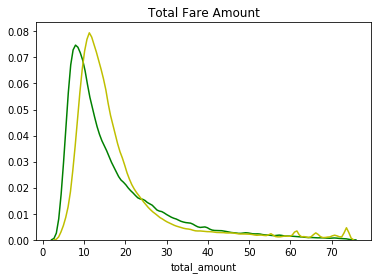

In [9]:
sns.distplot(df[df['cab'] == 'green']['total_amount'], hist=False, color = "green")
sns.distplot(df[df['cab'] == "yellow"]['total_amount'], hist=False, color = "y").set_title('Total Fare Amount')

In [10]:
df.groupby('cab')['total_amount'].mean()

cab
green     17.045930
yellow    18.389304
Name: total_amount, dtype: float64

On average, the total fare amount for yellow cabs is about $1 more than green cabs.

### Total Trip Time

Text(0.5, 1.0, 'Total Trip Time')

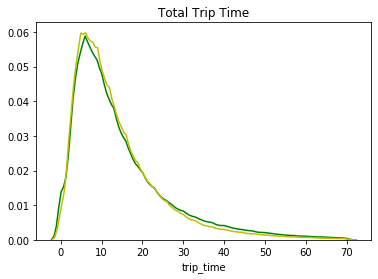

In [11]:
sns.distplot(df[df['cab']=="green"]['trip_time'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['trip_time'], hist = False, color = "y").set_title('Total Trip Time')

In [12]:
df.groupby('cab')['trip_time'].mean()

cab
green     14.671320
yellow    13.727183
Name: trip_time, dtype: float64

On average, the trip times are approximately the same between both cabs (13-14 minutes).

### Total Tip Amount

Text(0.5, 1.0, 'Total Tip Amount')

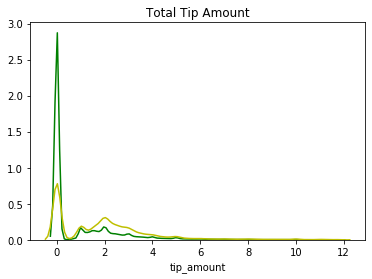

In [13]:
sns.distplot(df[df['cab']=="green"]['tip_amount'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['tip_amount'], hist = False, color = "y").set_title('Total Tip Amount')

In [14]:
df[df['tip_amount'] == 0].groupby('cab')['tip_amount'].count()

cab
green     322914
yellow    154617
Name: tip_amount, dtype: int64

There are a large portion of transactions have 0 tips for both cabs. For green, more than 60% transactions don't have tips, and for yellow apporximately 30%. Most of the 0 tip transactions are cash **(shown below - 'payment_type = 2')**. 

This could mean that taxi cab drivers do not record tip amounts for cash transcations (possibly for tax reasons).

In [25]:
df[df['tip_amount'] == 0].groupby(['cab', 'payment_type'])['payment_type'].count()

cab     payment_type
green   1.0              88364
        2.0             196598
yellow  1.0              14184
        2.0             135286
Name: payment_type, dtype: int64

Text(0.5, 1.0, 'Total Trip Distance')

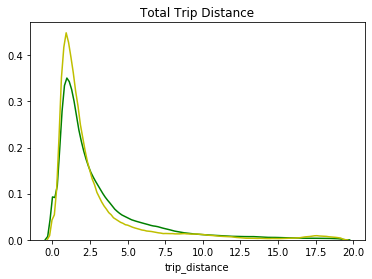

In [15]:
sns.distplot(df[df['cab']=="green"]['trip_distance'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['trip_distance'], hist = False, color = "y").set_title('Total Trip Distance')

In [16]:
df.groupby('cab')['trip_distance'].mean()

cab
green     3.124205
yellow    2.809604
Name: trip_distance, dtype: float64

In [28]:
df.groupby(['cab', 'payment_type'])['tip_amount'].describe()

count      mean       std  min   25%   50%   75%  \
cab    payment_type                                                        
green  1.0           264147.0  1.772391  1.908171  0.0  0.00  1.50  2.61   
       2.0           196606.0  0.000157  0.031392  0.0  0.00  0.00  0.00   
yellow 1.0           350992.0  2.769506  1.944149  0.0  1.66  2.26  3.32   
       2.0           135306.0  0.000352  0.035902  0.0  0.00  0.00  0.00   

                       max  
cab    payment_type         
green  1.0           11.78  
       2.0           10.21  
yellow 1.0           11.78  
       2.0            7.46

In [18]:
df.groupby('Borough')['tip_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Borough,,,,,,,,
Bronx,36142.0,0.198432,0.972581,0.0,0.0,0.0,0.00,11.76
Brooklyn,148220.0,1.089618,1.793506,0.0,0.0,0.0,1.86,11.77
EWR,22.0,2.868182,4.609657,0.0,0.0,0.0,8.00,11.10
Manhattan,622242.0,1.663713,1.792432,0.0,0.0,1.5,2.56,11.78
Queens,177360.0,1.282136,2.453465,0.0,0.0,0.0,1.74,11.78
Staten Island,269.0,0.335874,1.277569,0.0,0.0,0.0,0.00,7.60
Unknown,5947.0,1.527197,2.168200,0.0,0.0,1.0,2.26,11.78
